In [29]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
import time

In [76]:
#pip install statsmodels
#pip install bcb
from bcb import sgs
ipca = sgs.get(('IPCA', 433))
ipca = ipca[ipca.index >= '2000-01-01']
ipca2 = ipca[ipca.index >= '2003-01-01']
ipca2 = ipca2[ipca2.index <= '2013-12-01']

ipca.tail(5)

,IPCA
Date,
2024-02-01,0.83
2024-03-01,0.16
2024-04-01,0.38
2024-05-01,0.46
2024-06-01,0.21


In [59]:
ipca = sgs.get(('IPCA', 433))
ipca = ipca[ipca.index >= '2000-01-01']

# Garantir que o índice é do tipo datetime
ipca.index = pd.to_datetime(ipca.index)

# Criar um novo índice com frequência mensal
new_index = pd.date_range(start=ipca.index.min(), end=ipca.index.max(), freq='M')

# Reindexar o DataFrame com o novo índice
ipca = ipca.reindex(new_index)

# Preencher valores faltantes, se houver
ipca = ipca.fillna(method='ffill')

# Definir a frequência mensal
ipca.index.freq = 'M'

# Verificar a frequência e o DataFrame resultante
print(ipca.index.freq)
print(ipca)

<MonthEnd>
            IPCA
2000-01-31   NaN
2000-02-29   NaN
2000-03-31   NaN
2000-04-30   NaN
2000-05-31   NaN
2000-06-30   NaN
2000-07-31   NaN
2000-08-31   NaN
2000-09-30   NaN
2000-10-31   NaN
2000-11-30   NaN
2000-12-31   NaN
2001-01-31   NaN
2001-02-28   NaN
2001-03-31   NaN
2001-04-30   NaN
2001-05-31   NaN
2001-06-30   NaN
2001-07-31   NaN
2001-08-31   NaN
2001-09-30   NaN
2001-10-31   NaN
2001-11-30   NaN
2001-12-31   NaN
2002-01-31   NaN
2002-02-28   NaN
2002-03-31   NaN
2002-04-30   NaN
2002-05-31   NaN
2002-06-30   NaN
2002-07-31   NaN
2002-08-31   NaN
2002-09-30   NaN
2002-10-31   NaN
2002-11-30   NaN
2002-12-31   NaN
2003-01-31   NaN
2003-02-28   NaN
2003-03-31   NaN
2003-04-30   NaN
2003-05-31   NaN
2003-06-30   NaN
2003-07-31   NaN
2003-08-31   NaN
2003-09-30   NaN
2003-10-31   NaN
2003-11-30   NaN
2003-12-31   NaN
2004-01-31   NaN
2004-02-29   NaN
2004-03-31   NaN
2004-04-30   NaN
2004-05-31   NaN
2004-06-30   NaN
2004-07-31   NaN
2004-08-31   NaN
2004-09-30   NaN
200

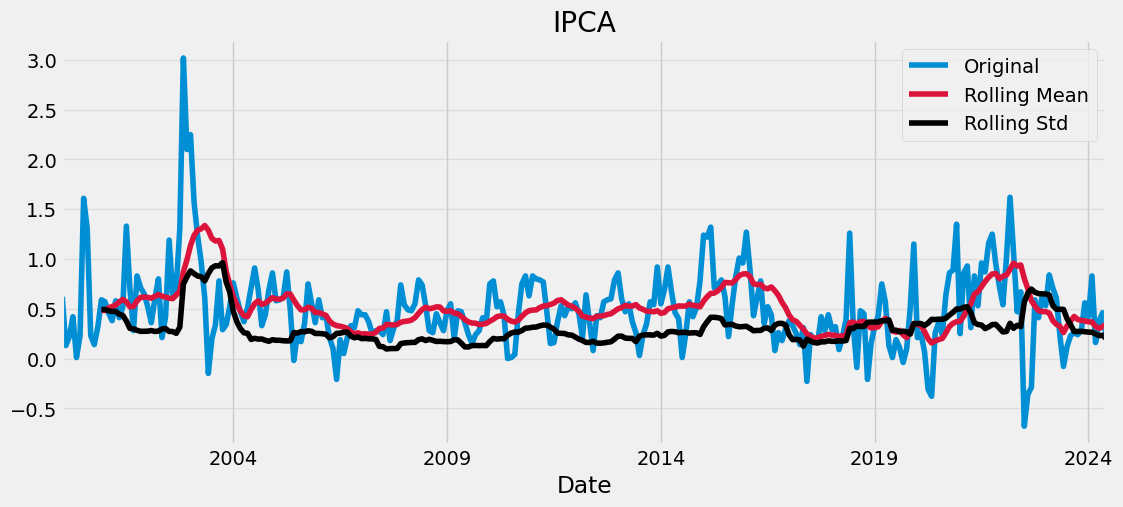

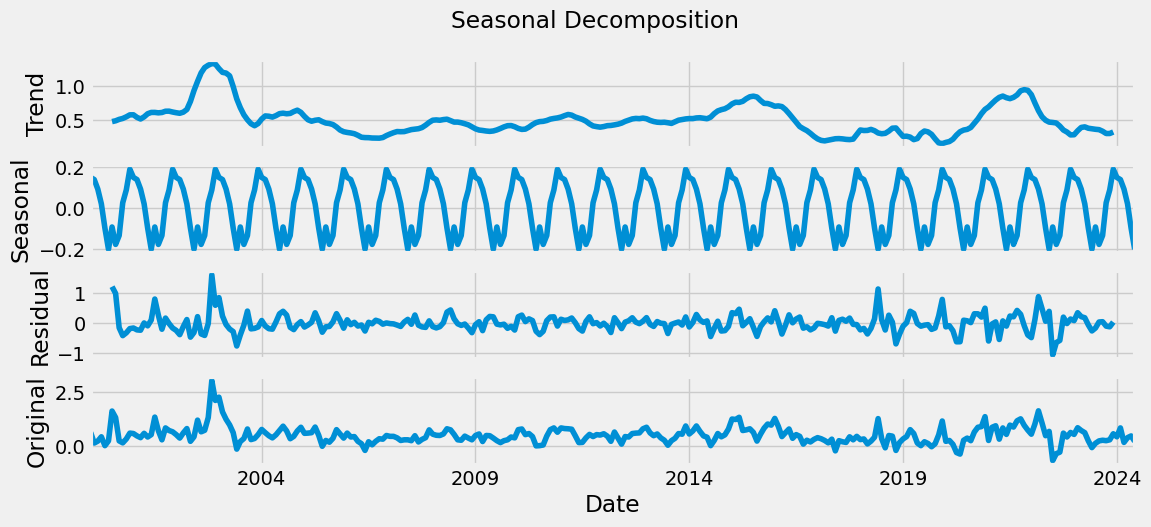

In [24]:
def plot_time_series(series):
    mean_rolling = series.rolling(window=12).mean()
    std_rolling = series.rolling(window=12).std()
    
    # plot inflation rates
    series.plot(figsize=(12, 5), label='Original')
    mean_rolling.plot(color='crimson', label='Rolling Mean')
    std_rolling.plot(color='black', label='Rolling Std')
    plt.title('IPCA')
    plt.grid(axis='y', alpha=0.5)
    plt.legend(loc='best')
    plt.show()
    
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    # plot decomposition components
    decomp = seasonal_decompose(series, model='additive')
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 5))
    fig.suptitle('Seasonal Decomposition')
    
    decomp.trend.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Trend')
    
    decomp.seasonal.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Seasonal')
    
    decomp.resid.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Residual')
    
    decomp.observed.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Original')
    plt.show()

plot_time_series(ipca['IPCA'])

In [25]:
def adf_test(series):
    from statsmodels.tsa.stattools import adfuller
    
    result = adfuller(series, regression='c', autolag='AIC')
    print('======= Augmented Dickey-Fuller Test Results =======\n')
    print('1. ADF Test Statistic: {:.6f}'.format(result[0]))
    print('2. P-value: {:.6f}'.format(result[1]))
    print('3. Used Lags: {}'.format(result[2]))
    print('4. Used Observations: {}'.format(result[3]))
    print('5. Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.6f}'.format(key, value))
    
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis.\
        Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')
    return

# run function
adf_test(ipca['IPCA'])

======= Augmented Dickey-Fuller Test Results =======

1. ADF Test Statistic: -8.226833
2. P-value: 0.000000
3. Used Lags: 0
4. Used Observations: 293
5. Critical Values:
	1%: -3.452867
	5%: -2.871455
	10%: -2.572053

Strong evidence against the null hypothesis (H0), reject the null hypothesis.        Data has no unit root and is stationary.


In [46]:
def find_optimal_orders(series, verbose=True):
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    import warnings
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import time
    
    # Start timer
    start_time = time.time()
    
    ######### List of possible combinations
    order_list = [(p, d, q) for p in range(0, 3) for d in range(0, 2) for q in range(0, 3)]
    
    ######### Initialize variables
    m = 12
    trend_pdq = order_list
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in order_list]
    min_aic = float('inf')
    best_params = {'order': None, 'seasonal_order': None}
    
    ######### Loop through every possible configuration and print results
    print('Expected Fits: {}'.format(len(trend_pdq) * len(seasonal_pdq)))
    print('========== SARIMAX Results ==========\n')
    count = 0
    for param in trend_pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(endog=series, order=param, seasonal_order=param_seasonal,
                                enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit()
                
                if verbose:
                    count += 1
                    print('{}. SARIMAX{}{}[{}],\tAIC = {:.6f},\tBIC = {:.6f}'.format(count, param,
                                                        param_seasonal[:-1], m, model_fit.aic, model_fit.bic))
                    
                if model_fit.aic < min_aic:
                    min_aic = model_fit.aic
                    best_params['order'] = param
                    best_params['seasonal_order'] = param_seasonal
                    line = count
            except Exception as e:
                print(f'Error while fitting model SARIMAX{param}{param_seasonal[:-1]}: {e}')
                continue
    print('\nBest order: {}{}[{}] with AIC = {:.6f} at line {}'.format(best_params['order'],
                                                             best_params['seasonal_order'][:-1], m, min_aic, line))
    
    # Stop timer and display execution time
    diff = time.time() - start_time
    print('\n(Total time of execution: {:.0f} min {:.2f} s)'.format(diff // 60, diff % 60))

# Testando com uma configuração reduzida
find_optimal_orders(ipca['IPCA'], verbose=True)

Expected Fits: 324
========== SARIMAX Results ==========

1. SARIMAX(0, 0, 0)(0, 0, 0)[12],	AIC = 573.186314,	BIC = 576.866486
2. SARIMAX(0, 0, 0)(0, 0, 1)[12],	AIC = 450.264581,	BIC = 457.541290
3. SARIMAX(0, 0, 0)(0, 0, 2)[12],	AIC = 408.824679,	BIC = 419.608813
4. SARIMAX(0, 0, 0)(0, 1, 0)[12],	AIC = 424.103381,	BIC = 427.741736
5. SARIMAX(0, 0, 0)(0, 1, 1)[12],	AIC = 287.525241,	BIC = 294.714664
6. SARIMAX(0, 0, 0)(0, 1, 2)[12],	AIC = 229.120730,	BIC = 239.767958
7. SARIMAX(0, 0, 0)(1, 0, 0)[12],	AIC = 373.774742,	BIC = 381.058556
8. SARIMAX(0, 0, 0)(1, 0, 1)[12],	AIC = 292.608178,	BIC = 303.523242
9. SARIMAX(0, 0, 0)(1, 0, 2)[12],	AIC = 269.976858,	BIC = 284.355704
10. SARIMAX(0, 0, 0)(1, 1, 0)[12],	AIC = 362.105194,	BIC = 369.302038
11. SARIMAX(0, 0, 0)(1, 1, 1)[12],	AIC = 279.661502,	BIC = 290.445636
12. SARIMAX(0, 0, 0)(1, 1, 2)[12],	AIC = 201.108843,	BIC = 215.305148
13. SARIMAX(0, 0, 0)(2, 0, 0)[12],	AIC = 337.584144,	BIC = 348.379410
14. SARIMAX(0, 0, 0)(2, 0, 1)[12],	AIC = 

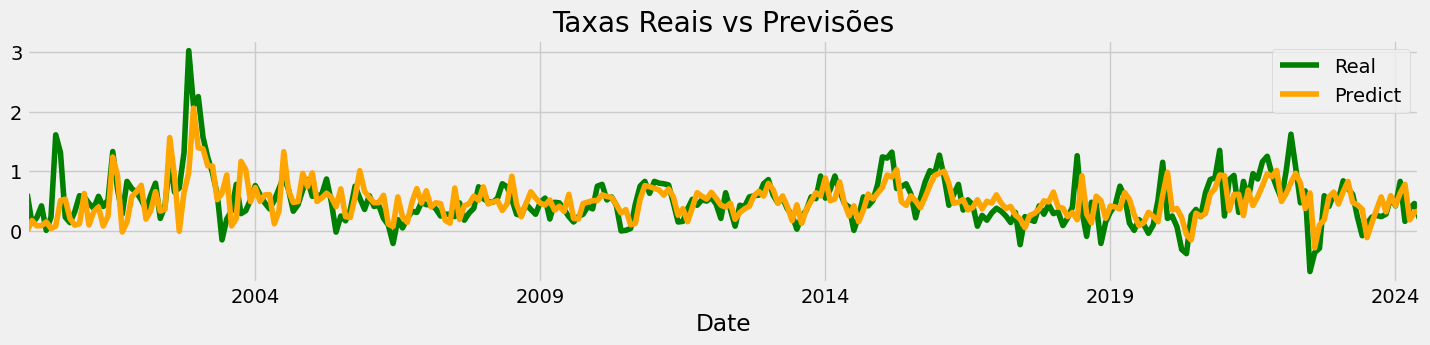

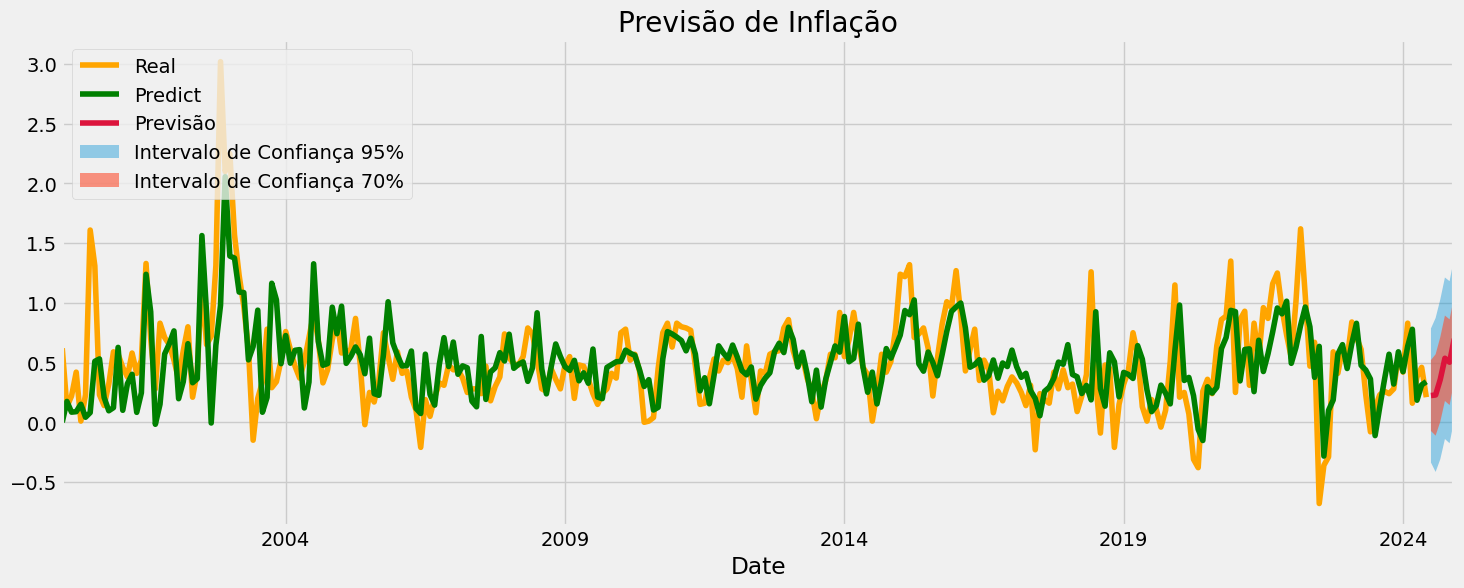

,Previsão [%]
2024-07-01,0.2
2024-08-01,0.2
2024-09-01,0.4
2024-10-01,0.5
2024-11-01,0.5
2024-12-01,0.7


In [65]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX

def forecast_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    
    # Determinar a frequência do índice
    if series.index.freq is None:
        series = series.asfreq(pd.infer_freq(series.index))
    
    # Desenvolver o modelo
    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, exog=exog,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # Previsões
    yhat = model_fit.predict(start=series.index[0], end=series.index[-1], typ='levels', dynamic=False).rename('Predict')

    # Previsão e intervalos de confiança 70% e 95%
    conf_int_70 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.3)
    conf_int_95 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.05)
    
    # Extrair lista de índices
    indx_list = conf_int_95.index
    
    # 1º gráfico - taxas reais vs previstas
    plt.figure(figsize=(16, 3))
    series.plot(legend=True, label='Real', color='green')
    yhat.plot(legend=True, color='orange')
    plt.title('Taxas Reais vs Previsões')
    plt.legend()
    plt.show()
    
    # 2º gráfico - resultados da previsão
    plt.figure(figsize=(16, 6))
    series.plot(legend=True, label='Real', color='orange')
    yhat.plot(legend=True, color='green')
    conf_int_95['mean'].plot(legend=True, label='Previsão', color='crimson')
    # Intervalos de confiança 95%
    plt.fill_between(x=indx_list, y1=conf_int_95['mean_ci_upper'], y2=conf_int_95['mean_ci_lower'],
                     alpha=0.4, label='Intervalo de Confiança 95%', linewidth=0)
    # Intervalos de confiança 70%
    plt.fill_between(x=indx_list, y1=conf_int_70['mean_ci_upper'], y2=conf_int_70['mean_ci_lower'],
                     alpha=0.6, label='Intervalo de Confiança 70%', linewidth=0)
    plt.title('Previsão de Inflação')
    plt.legend(loc='upper left')
    plt.show()
    
    # Exibir taxas previstas
    return pd.DataFrame(round(conf_int_95['mean'], 1)).rename({'mean': 'Previsão [%]'}, axis=1)

# Exemplo de uso
# Assumindo que 'ipca' é um DataFrame com a coluna 'IPCA' e o índice como datas
forecast_SARIMA(series=ipca['IPCA'], order=(1, 0, 0), seasonal_order=(1, 1, 2, 12))

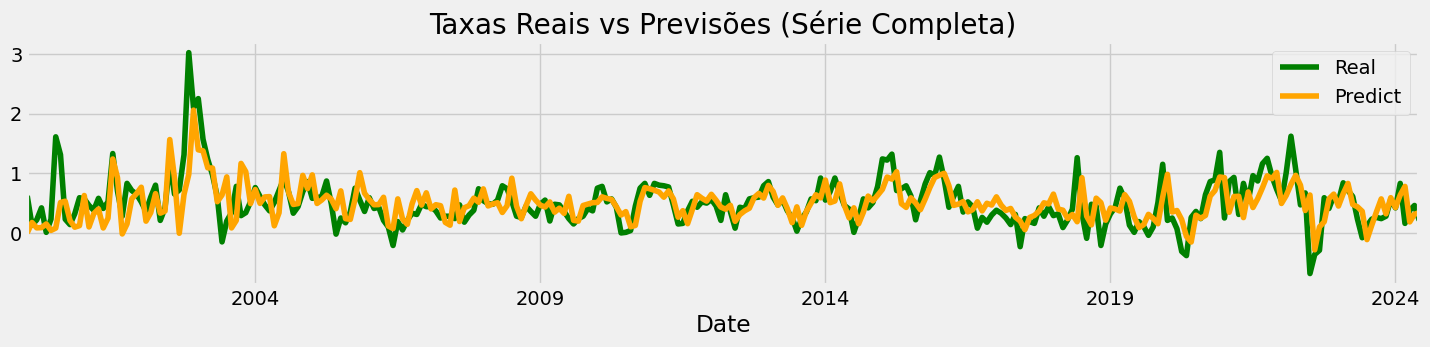

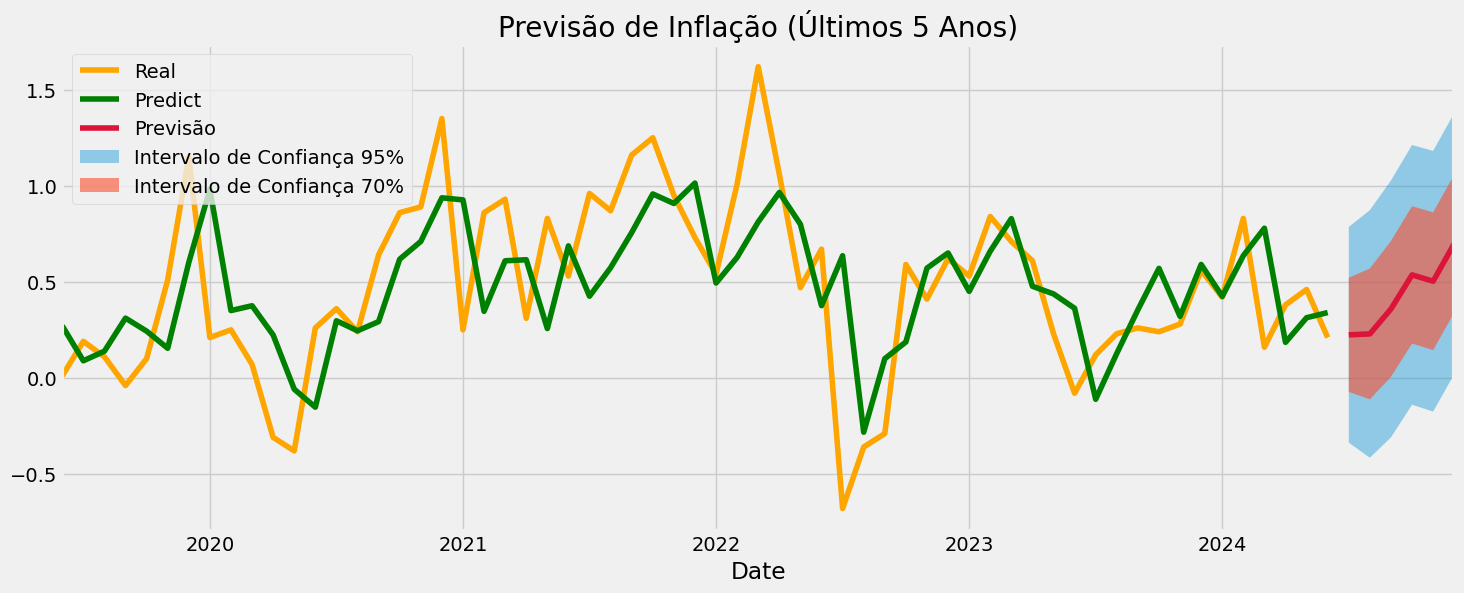

,Previsão [%]
2024-07-01,0.2
2024-08-01,0.2
2024-09-01,0.4
2024-10-01,0.5
2024-11-01,0.5
2024-12-01,0.7


In [80]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX

def forecast_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    
    # Determinar a frequência do índice
    if series.index.freq is None:
        series = series.asfreq(pd.infer_freq(series.index))
    
    # Desenvolver o modelo
    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, exog=exog,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # Previsões
    yhat = model_fit.predict(start=series.index[0], end=series.index[-1], typ='levels', dynamic=False).rename('Predict')

    # Previsão e intervalos de confiança 70% e 95%
    conf_int_70 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.3)
    conf_int_95 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.05)
    
    # Extrair lista de índices
    indx_list = conf_int_95.index
    
    # Determinar o intervalo de 5 anos para exibir no segundo gráfico
    end_date = series.index[-1]
    start_date_5_years = end_date - pd.DateOffset(years=5)

    # 1º gráfico - taxas reais vs previstas (série completa)
    plt.figure(figsize=(16, 3))
    series.plot(legend=True, label='Real', color='green')
    yhat.plot(legend=True, color='orange')
    plt.title('Taxas Reais vs Previsões (Série Completa)')
    plt.legend()
    plt.show()
    
    # 2º gráfico - resultados da previsão (últimos 5 anos)
    plt.figure(figsize=(16, 6))
    series.loc[start_date_5_years:].plot(legend=True, label='Real', color='orange')
    yhat.loc[start_date_5_years:].plot(legend=True, color='green')
    conf_int_95['mean'].loc[start_date_5_years:].plot(legend=True, label='Previsão', color='crimson')
    # Intervalos de confiança 95%
    plt.fill_between(x=indx_list, y1=conf_int_95['mean_ci_upper'].loc[start_date_5_years:], y2=conf_int_95['mean_ci_lower'].loc[start_date_5_years:],
                     alpha=0.4, label='Intervalo de Confiança 95%', linewidth=0)
    # Intervalos de confiança 70%
    plt.fill_between(x=indx_list, y1=conf_int_70['mean_ci_upper'].loc[start_date_5_years:], y2=conf_int_70['mean_ci_lower'].loc[start_date_5_years:],
                     alpha=0.6, label='Intervalo de Confiança 70%', linewidth=0)
    plt.title('Previsão de Inflação (Últimos 5 Anos)')
    plt.legend(loc='upper left')
    plt.show()
    
    # Exibir taxas previstas
    return pd.DataFrame(round(conf_int_95['mean'], 1)).rename({'mean': 'Previsão [%]'}, axis=1)

# Exemplo de uso
# Assumindo que 'ipca' é um DataFrame com a coluna 'IPCA' e o índice como datas
forecast_SARIMA(series=ipca['IPCA'], order=(1, 0, 0), seasonal_order=(1, 1, 2, 12))



In [77]:
find_optimal_orders(ipca2['IPCA'], verbose=True)

Expected Fits: 324
========== SARIMAX Results ==========

1. SARIMAX(0, 0, 0)(0, 0, 0)[12],	AIC = 207.911665,	BIC = 210.786862
2. SARIMAX(0, 0, 0)(0, 0, 1)[12],	AIC = 93.816426,	BIC = 99.374673
3. SARIMAX(0, 0, 0)(0, 0, 2)[12],	AIC = 68.074426,	BIC = 76.092912
4. SARIMAX(0, 0, 0)(0, 1, 0)[12],	AIC = 58.869420,	BIC = 61.648543
5. SARIMAX(0, 0, 0)(0, 1, 1)[12],	AIC = -12.265455,	BIC = -6.919797
6. SARIMAX(0, 0, 0)(0, 1, 2)[12],	AIC = -30.032934,	BIC = -22.371303
7. SARIMAX(0, 0, 0)(1, 0, 0)[12],	AIC = 51.411068,	BIC = 56.986052
8. SARIMAX(0, 0, 0)(1, 0, 1)[12],	AIC = 20.761595,	BIC = 29.098966
9. SARIMAX(0, 0, 0)(1, 0, 2)[12],	AIC = -7.847578,	BIC = 2.843738
10. SARIMAX(0, 0, 0)(1, 1, 0)[12],	AIC = 10.069239,	BIC = 15.433501
11. SARIMAX(0, 0, 0)(1, 1, 1)[12],	AIC = -8.043797,	BIC = -0.025311
12. SARIMAX(0, 0, 0)(1, 1, 2)[12],	AIC = -31.147741,	BIC = -20.932233
13. SARIMAX(0, 0, 0)(2, 0, 0)[12],	AIC = 2.355345,	BIC = 10.401739
14. SARIMAX(0, 0, 0)(2, 0, 1)[12],	AIC = -6.202667,	BIC = 4.52

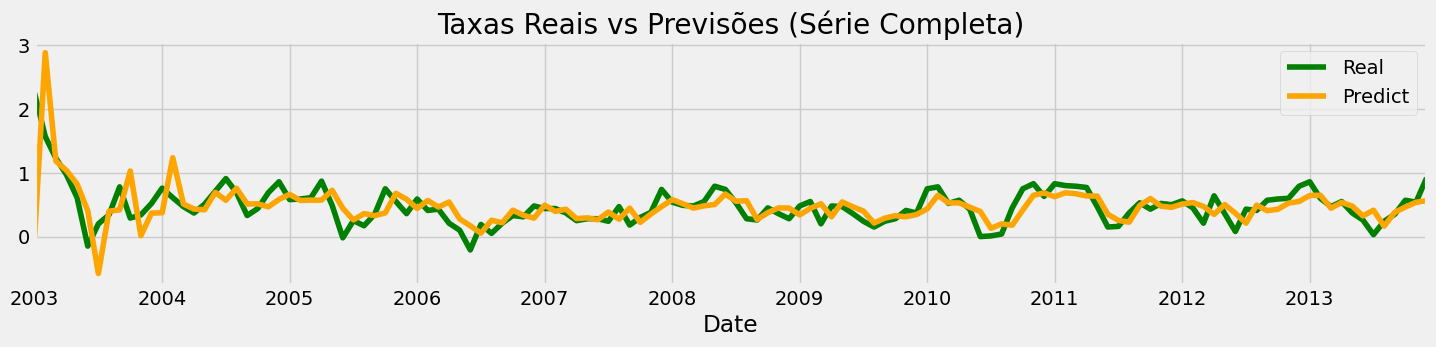

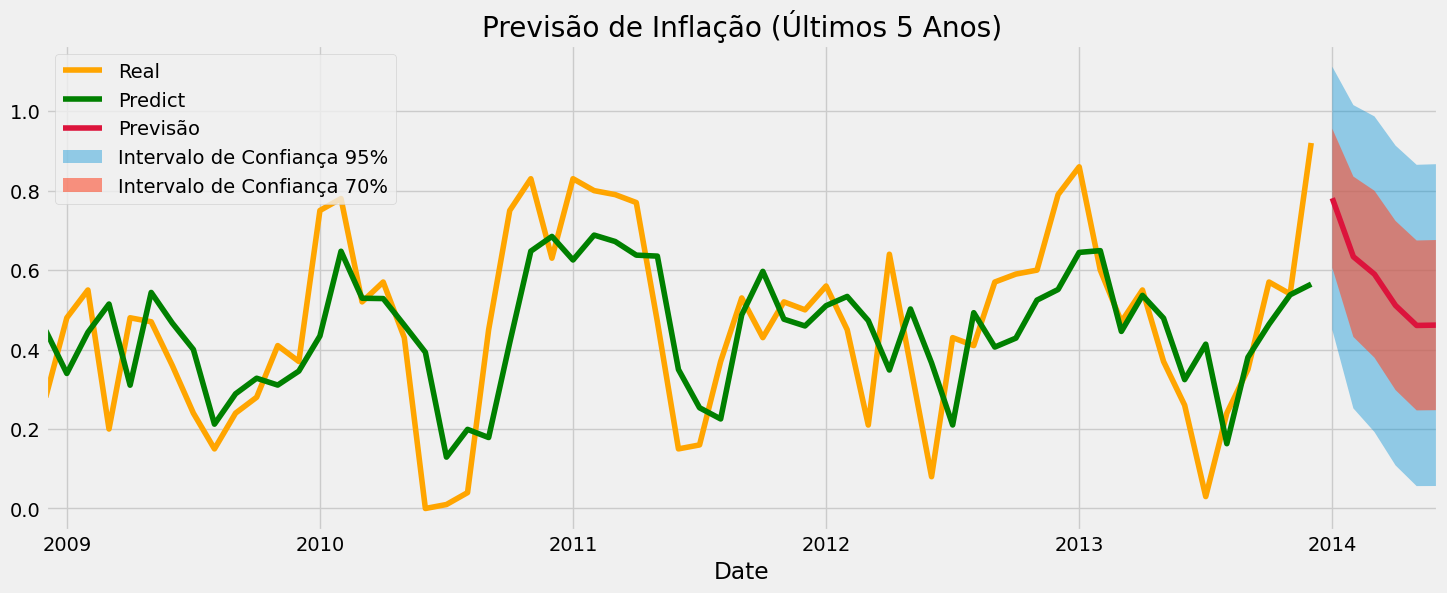

,Previsão [%]
2014-01-01,0.8
2014-02-01,0.6
2014-03-01,0.6
2014-04-01,0.5
2014-05-01,0.5
2014-06-01,0.5


In [78]:
forecast_SARIMA(series=ipca2['IPCA'], order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))


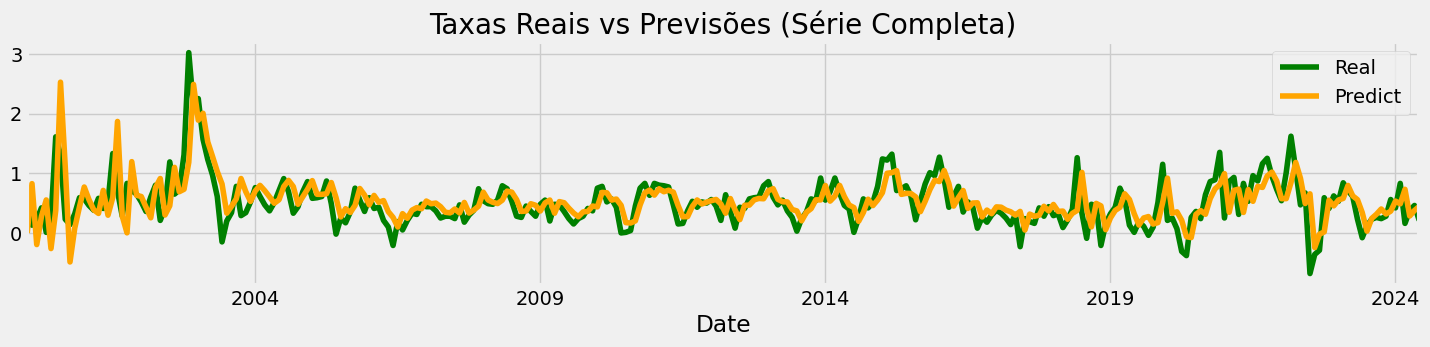

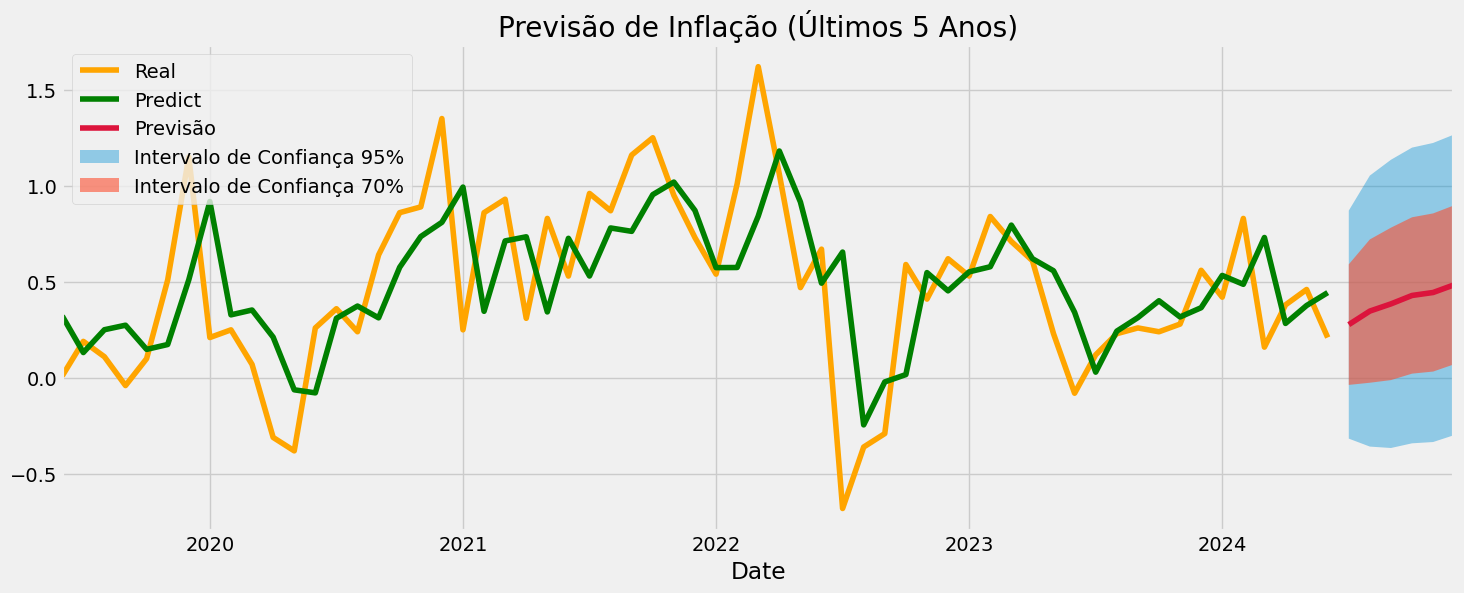

,Previsão [%]
2024-07-01,0.3
2024-08-01,0.3
2024-09-01,0.4
2024-10-01,0.4
2024-11-01,0.4
2024-12-01,0.5


In [81]:
forecast_SARIMA(series=ipca['IPCA'], order=(1, 1, 2), seasonal_order=(0, 0, 2, 12))